# LOGISTIC REGRESSION

The data used here comes from Kaggle: https://www.kaggle.com/rakeshrau/social-network-ads

The dependent or outcome variable is "Purchased" (i.e., whether or not users purchased and SUV)

## Exploring Data

In [228]:
# import necessary libraries

import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

path = 'C:/Users/Katia/Documents/Machine learning'
os.chdir(path)

In [229]:
# read csv data 

# Check README for where you can find the data
df = pd.read_csv('Social_Network_Ads.csv')

In [230]:
# Check dataset
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [231]:
# Check descriptive statistics of continuous variables
df.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


In [232]:
# Check if there are any missing values
df.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

The descriptive statistics suggest that there is good variation regarding estimated salary (it may be a variable in need of transformation). User ID does not seem to be a useful variable.

### Explore distributions and relationship between variables

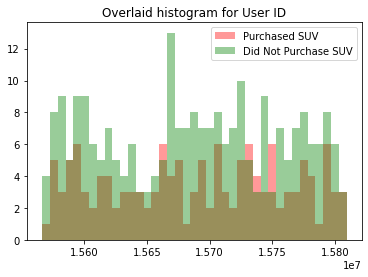

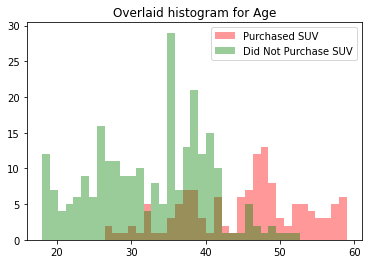

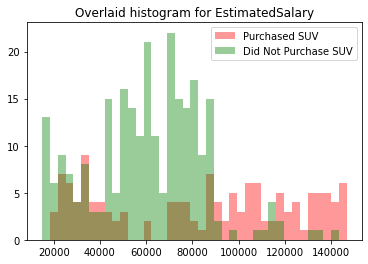

In [233]:
# Create overlaid histograms
for i in ['User ID', 'Age', 'EstimatedSalary']:
    purchase = list(df[df['Purchased'] == 1][i].dropna())
    no_purchase = list(df[df['Purchased'] == 0][i].dropna())
    xmin = min(min(purchase), min(no_purchase))
    xmax = max(max(purchase), max(no_purchase))
    width = (xmax - xmin) / 40
    sns.distplot(purchase, color='r', kde=False, bins=np.arange(xmin, xmax, width))
    sns.distplot(no_purchase, color='g', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['Purchased SUV', 'Did Not Purchase SUV'])
    plt.title('Overlaid histogram for {}'.format(i))
    plt.show()

The histograms suggest that older users with higher salaries bought SUVs more than younger users with lower salaries.

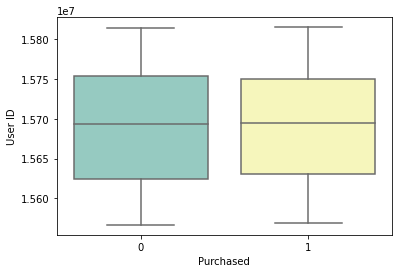

In [234]:
sns.boxplot(df['Purchased'], df['User ID'], palette="Set3") #palette set3 reduce transparency

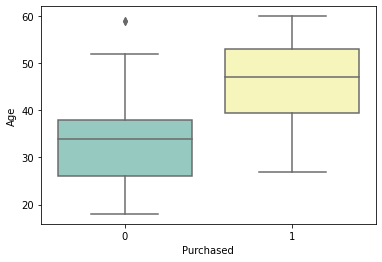

In [235]:
sns.boxplot(df['Purchased'], df['Age'], palette="Set3") #palette set3 reduce transparency

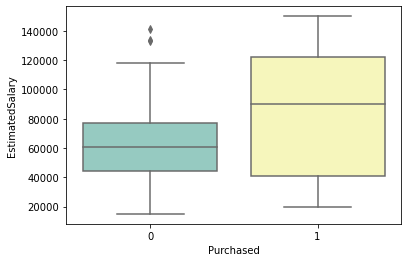

In [236]:
sns.boxplot(df['Purchased'], df['EstimatedSalary'], palette="Set3") #palette set3 reduce transparency

Age is a clear factor influencing purchase, whereas salary varied substancially among those who purchased an SUV. Again, User ID does not seem to be a useful variable.

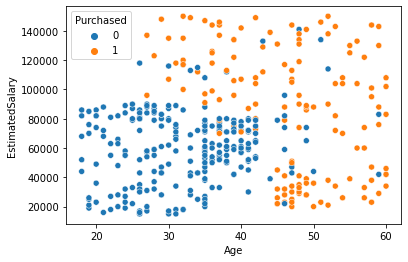

In [237]:
sns.scatterplot(df['Age'], df['EstimatedSalary'], hue= df['Purchased'])

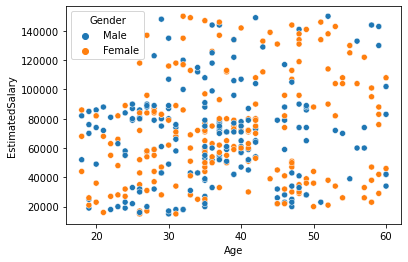

In [238]:
sns.scatterplot(df['Age'], df['EstimatedSalary'], hue= df['Gender'])

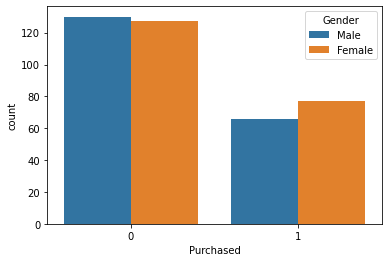

In [239]:
sns.countplot(df['Purchased'], hue = df['Gender'])

Females bought SUVs more than males, but the difference does not seem very big. It is still worth testing Gender as a predictor.

Drop meaningless variables.

In [240]:
df = df.drop(['User ID'], axis = 1)
df.head()

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


## Remove outliers

In [241]:
def outlier(feature):
    outliers = []
    data = df[feature]
    mean = np.mean(data)
    std =np.std(data)
    
    for value in data:
        z_score= (value - mean)/std 
        if np.abs(z_score) > 3:
            outliers.append(value)
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:.1f} / {} values exceed that'.format(data.quantile(.95),
                                                             len([i for i in data
                                                                  if i > data.quantile(.95)])))
    print('  --3sd: {:.1f} / {} values exceed that'.format(mean + 3*(std), len(outliers)))
    print('  --99p: {:.1f} / {} values exceed that'.format(data.quantile(.99),
                                                           len([i for i in data
                                                                if i > data.quantile(.99)])))
    
# function from https://www.linkedin.com/learning/applied-machine-learning-feature-engineering

In [242]:
for variable in ['Age', 'EstimatedSalary']:
    outlier(variable)


Outlier caps for Age:
  --95p: 57.0 / 20 values exceed that
  --3sd: 69.1 / 0 values exceed that
  --99p: 60.0 / 0 values exceed that

Outlier caps for EstimatedSalary:
  --95p: 137050.0 / 20 values exceed that
  --3sd: 171905.4 / 0 values exceed that
  --99p: 148010.0 / 4 values exceed that


In [243]:
# Remove outliers based on 99 quantile

df['EstimatedSalary'].clip(upper=df['EstimatedSalary'].quantile(.99), inplace = True)

In [244]:
df.describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69727.600000,0.357500
std,10.482877,34062.288502,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,148010.000000,1.000000


Transformations are not required for logistic regression, so after checking for multicollinearity, we can build the regression models.

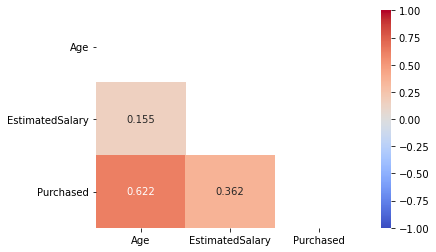

In [245]:
# Generate correlation matrix heat map
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, fmt='.3f', vmin=-1, 
            vmax=1, center= 0, cmap='coolwarm', mask=matrix)

## Encode categorical variables

In [246]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Gender_encoded"] = le.fit_transform(df["Gender"].astype(str))
    
df.head()

,Gender,Age,EstimatedSalary,Purchased,Gender_encoded
0,Male,19,19000,0,1
1,Male,35,20000,0,1
2,Female,26,43000,0,0
3,Female,27,57000,0,0
4,Male,19,76000,0,1


## Split data into training, test, and validation

In [247]:
from sklearn.model_selection import train_test_split

df_trans = df.drop(['Gender', 'Purchased'], axis =1)
labels = df['Purchased']

X_train, X_test, y_train, y_test = train_test_split(df_trans, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train.describe()

,Age,EstimatedSalary,Gender_encoded
count,240.000000,240.000000,240.000000
mean,37.595833,69995.916667,0.500000
std,10.182394,33665.106540,0.501045
min,18.000000,15000.000000,0.000000
25%,30.000000,44750.000000,0.000000
50%,37.000000,69500.000000,0.500000
75%,45.000000,87250.000000,1.000000
max,60.000000,148010.000000,1.000000


In [248]:
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len(labels), 2))

0.6
0.2
0.2


## Scale variables

In [249]:
from sklearn.preprocessing import StandardScaler

# Fit the scaler on the training data
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [250]:
# Scale the training, test, and validation sets
variables = X_train.columns

X_train[variables] = scaler.transform(X_train[variables])
X_val[variables] = scaler.transform(X_val[variables])
X_test[variables] = scaler.transform(X_test[variables])

X_train.head()

C:\Users\katia\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\katia\Anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,Age,EstimatedSalary,Gender_encoded
375,0.827087,-1.131003,-1.0
208,0.236604,2.143304,-1.0
286,-0.058638,-0.238010,-1.0
168,-0.845950,2.321903,1.0
353,-0.058638,-0.386842,-1.0


## Logistic Regression with Statsmodel

In [251]:
# Put the outcome variable back to the files to run the formula version of Statsmodel
X_train['Purchased'] = y_train
X_val['Purchased'] = y_val
X_test['Purchased'] = y_test

X_val.head()

C:\Users\katia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Age,EstimatedSalary,Gender_encoded,Purchased
285,-0.058638,0.684749,-1.0,1
289,-0.058638,0.238253,-1.0,1
141,-1.928504,-0.059411,-1.0,0
220,0.335018,0.297786,-1.0,0
103,-0.452294,2.322200,-1.0,1


In [252]:
# import statsmodel
import statsmodels.formula.api as sm 

# build the model and fit the data 
model = sm.logit(formula="Purchased ~ EstimatedSalary + Gender_encoded + Age", data = X_train).fit() 

Optimization terminated successfully.
         Current function value: 0.373786
         Iterations 7


In [253]:
print(model.summary()) 

                           Logit Regression Results                           
Dep. Variable:              Purchased   No. Observations:                  240
Model:                          Logit   Df Residuals:                      236
Method:                           MLE   Df Model:                            3
Date:                Tue, 24 Nov 2020   Pseudo R-squ.:                  0.4203
Time:                        21:51:26   Log-Likelihood:                -89.709
converged:                       True   LL-Null:                       -154.76
Covariance Type:            nonrobust   LLR p-value:                 5.145e-28
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.1232      0.208     -5.412      0.000      -1.530      -0.716
EstimatedSalary     1.2219      0.224      5.467      0.000       0.784       1.660
Gender_encoded      0.1208      

In [254]:
# Remove variables that are not significant
model2 = sm.logit(formula="Purchased ~ EstimatedSalary + Age", data = X_train).fit() 
print(model2.summary()) 

Optimization terminated successfully.
         Current function value: 0.374636
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Purchased   No. Observations:                  240
Model:                          Logit   Df Residuals:                      237
Method:                           MLE   Df Model:                            2
Date:                Tue, 24 Nov 2020   Pseudo R-squ.:                  0.4190
Time:                        21:51:28   Log-Likelihood:                -89.913
converged:                       True   LL-Null:                       -154.76
Covariance Type:            nonrobust   LLR p-value:                 6.880e-29
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.1150      0.207     -5.398      0.000      -1.520      -0.710
EstimatedSalar

In [255]:
# perform predictions on the test set
y_pred = model2.predict(X_test) 
prediction_test = list(map(round, y_pred)) 
  
# original and predicted values of y 
print('Acutal values', list(y_test.values)) 
print('Predictions :', prediction_test) 

Acutal values [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Predictions : [1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]


In [256]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, prediction_test))
print("Precision:",metrics.precision_score(y_test, prediction_test))
print("Recall:",metrics.recall_score(y_test, prediction_test))

Accuracy: 0.8875
Precision: 0.9333333333333333
Recall: 0.8


In [257]:
# perform predictions on the val set
y_pred = model2.predict(X_val) 
prediction_val = list(map(round, y_pred)) 
  
# original and predicted values of y 
print('Acutal values', list(y_val.values)) 
print('Predictions :', prediction_val) 

Acutal values [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1]
Predictions : [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [258]:
print("Accuracy:",metrics.accuracy_score(y_val, prediction_val))
print("Precision:",metrics.precision_score(y_val, prediction_val))
print("Recall:",metrics.recall_score(y_val, prediction_val))

Accuracy: 0.825
Precision: 0.8235294117647058
Recall: 0.56


You can obtain prediction for an individual person

In [259]:
# For the sake of exemplifying, I will create a fake data of scaled/transformed values
new_data= pd.DataFrame({"EstimatedSalary": [2]})
new_data['Age'] = .3

new_data.head()

,EstimatedSalary,Age
0,2,0.3


In [260]:
model2.predict(new_data)

0    0.874496
dtype: float64

In [261]:
# Confusion matrix

cnf_matrix = metrics.confusion_matrix(y_test, prediction_test)
cnf_matrix

array([[43,  2],
       [ 7, 28]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

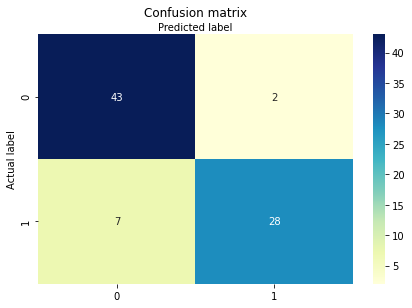

In [262]:
# Confursion matrix with heatmap from https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

The final model with two predictors (estimated salary and age) had good accuracy and prediction both in the validation and test set. Recall was low when the model was trained with the validation set. The confusion matrix also suggested a fair classification, with higher true positives and true negatives.